# Logistic Regression

How can we perform model fitting when the response variables are categorical?
Let's loo at the Wickham smoking experiment dataset; in which women were asked if they smoke or not; then 20 years later, followed up to see if they were still alive.


## Objective
* Convert smoking outcome to binary numbers
* Fit a model that includes smoking status and age as main terms
* Perform logistic regressionn and limit the output model to values between 0 and 1 that can be understood as the probability of 1 of the 2 outcomes

In [12]:
# Standard imports
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fix error in some versions of statsmodels
import scipy
if not hasattr(scipy.stats,'chisqprob'):
    scipy.stats.chisqprob = lambda chisq, df: scipy.stats.chi2.sf(chisq, df)

In [13]:
# Load Wickham smoking experiment dataset
smoking = pd.read_csv("whickham.csv")

In [14]:
# To improve strength of conclusions, remove cases with age > 65
smoking = smoking[smoking.age < 65]

If we convert the smoking outcome to binary numbers, it becomes possible to do ordinary least squares. Let's try that first, although we'll see there is a much better way.

In [30]:
color = np.where(smoking.smoker == 'No','#728EB1','#C8686E')
# Add jitters: move points randomly up and down so they don't lie on top of each other
jitter = 0.05*(np.random.rand(len(smoking)) - 0.5)
def plotfit(fit):
    plt.scatter(smoking.age,smoking.outcome + jitter,c=color,linewidth=0.2,edgecolor='k',alpha=0.5)
    plt.scatter(smoking.age,fit.predict(smoking),c=color,linewidth=0.2,edgecolor='gray',marker='d')

We can use a Python trick, multiplying a Boolean by an integer returns an integer. Let's fit a model that includes smoking status and age as main terms:

In [16]:
smoking['outcome'] = 1*(smoking['outcome'] == 'Alive')

In [18]:
ols_group_age = smf.ols('outcome ~ smoker + age', data=smoking).fit()

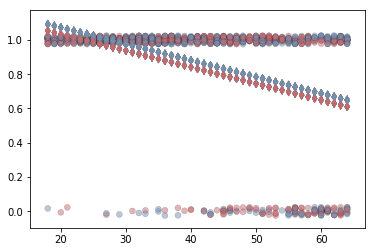

In [31]:
plotfit(ols_group_age)

In [21]:
ols_group_age.params

Intercept        1.264665
smoker[T.Yes]   -0.038738
age             -0.009615
dtype: float64

The data is plotted as cicles, with pink for smokers and blue for non-smokers. The fit is represented by the diamonds at the top. We do see there is an association between smoking and negative outcomes. The smoker term in negative.

In [22]:
sm.stats.anova_lm(ols_group_age)

,df,sum_sq,mean_sq,F,PR(>F)
smoker,1.0,0.899981,0.899981,8.181417,4.314608e-03
age,1.0,17.713821,17.713821,161.030213,1.806638e-34
Residual,1068.0,117.483303,0.110003,NaN,NaN


In [23]:
ols_group_age.conf_int()

,0,1
Intercept,1.198828,1.330503
smoker[T.Yes],-0.078622,0.001146
age,-0.011102,-0.008129


The association is not especially strong with an F-statistic of 8. We have confirmation of this in the confidnece intervla the stats models provides for the parameters. Those rely on specific mathematical assumptions about the data and should be taken with a grain of salt. The plot however, shows a mathematical problem: some predicted outcomes are larger than 1. We need to limit the output model to values 0 and 1; Or even better, to values between 0 and 1 that can be understood as the probability of 1 of the 2 outcomes.

In [24]:
logit_smoker_age = smf.logit('outcome ~ smoker + age', data=smoking).fit()

Optimization terminated successfully.
         Current function value: 0.346766
         Iterations 7


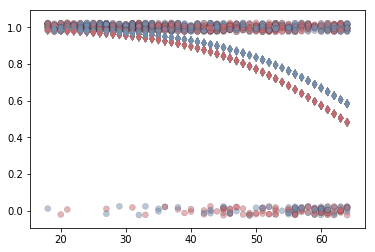

In [25]:
plotfit(logit_smoker_age)

We now see that the model is bounded between 0 and 1 and it displays a non-linear behavior, even though we have all linear main terms. The criteria for logistic regression in not minimizing the mean-square error of the residuals. But rather interpreting the model response as a probability function and maximizing the resulting probability of the observed data. This is a form of maximum-likelihood estimation. So instead of the main square error, the simplist way to characterize goodness of fit is the value of the likelihood. 

In [32]:
logit_smoker_age.llf

-371.38650786619064

In [33]:
logit_smoker_age.params

Intercept        6.250847
smoker[T.Yes]   -0.408103
age             -0.092403
dtype: float64

Stats models give us its logaritm. Becuase of the logistic transformation, the model parameters are not directly comparable with the least squares paramters. Smoking reduces the probabilty of being alive, but not uniformly. It does so by 10% at the upper end of the ages, and less for younger subjects. From the confidence intervals we see that the association with smoking remains weak.

In [34]:
logit_smoker_age.conf_int()

,0,1
Intercept,5.331126,7.170568
smoker[T.Yes],-0.777754,-0.038451
age,-0.109478,-0.075327


In [35]:
logit_smoker_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                 1071
Model:                          Logit   Df Residuals:                     1068
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Nov 2018   Pseudo R-squ.:                  0.1776
Time:                        16:54:39   Log-Likelihood:                -371.39
converged:                       True   LL-Null:                       -451.59
                                        LLR p-value:                 1.469e-35
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2508      0.469     13.321      0.000       5.331       7.171
smoker[T.Yes]    -0.4081      0.189     -2.164      0.030      -0.778      -0.038
age              -0.0924      0.009    -10.606      0.000      -0.109      -0.075
=================================================================================
"""

Note that the logistic model probabilities are conditional probabilities. They depend on the value of explanatory variables and they refer directly to the cases in the data set, but not necessarily to the general population. Unless we can determine that the sample is truly representative of the population. 